## Example: maxEnt interpretation of artifical neural network (ANN) pediciting CTCF binding from ChIP-seq data

This notebook demonstrates use of maxEnt code by interpreting inputs to an ANN trained on CTCF ChIP-seq data from the ENCODE project. The training and test sets were constructed by [1]. Positive elements (belonging to class 1) are 101 bp sequences centered on ChIP-seq peaks, negtive elements (belonging to class 0) are shuffled sequences from the positive class that preserve dinucleoitde frequency. 

The ANN is implemented as a Keras Sequential model and uses the following architecure:
+ input layer
+ convolutional layer with 64 filters, each taking 24 bp intervals as input and using ReLU activation functions
+ 100 unit fully connected  layer, using ReLU activations
+  2 unit fully connected layer with softmax activation funciton that encodes predicted class

The network achieves test AUROC of 0.978 

  MaxEnt interpretation identifies learned features in an individual network input, $\mathbf{x}$. This is accomplished by sampling a maximum entropy distribuion that is constrained to reproduce
  1. the hidden activation elecited by $\mathbf{x}$
  2. the single nucleotide content of the genome from which network inputs are derived. 
   
  
To preform the sampling we have to specify the hidden layer and distribution over single nucleotides that constrain the MaxEnt distribution. This is  demonstred below:


In [2]:
from __future__ import division
import numpy as np
import keras
from maxEnt.sampleConstrainedME import  layerSampler
from maxEnt import MEutils
import matplotlib.pyplot as plt

Using Theano backend.


Load the model and data (note the form of one-hot encoding used for this data)

In [3]:
## load some example data 1 hot encoded with shape  (nbInputs , seqLen, 4 )
## the 1hot encoding scheme is:
##  + oneHotSeqs[x,y,0] = 1 implies G at position y of sequence x
##  + oneHotSeqs[x,y,1] = 1 implies C at position y of sequence x
##  +  oneHotSeqs[x,y,2]  = 1 implies A at position y of sequence x
##  +  oneHotSeqs[x,y,3] = 1 implies T at position y of sequence x
oneHotSeqs = np.load("demoData/CTCFbound_oneHot.npy")
## load keras sequential model
modelHD5_path= "demoData/CTCF_network.hd5"
model = keras.models.load_model(modelHD5_path)

WARNING (theano.gof.cmodule): WARNING: your Theano flags `gcc.cxxflags` specify an `-march=X` flags.
         It is better to let Theano/g++ find it automatically, but we don't do it now


### Choosing the hidden layer used to constrain the MaxEnt distribution.
We recommend constraining based on the hidden activation of the penultimate layer. This is becuase the penultilmate activation elicited by an input sequence corresponds to the most abstract representation of the sequence learned by the ANN for its classification task. This representation has eliminated classification irrelevant information from the input and  retains information (encoded in the penultimate activtaion) is passed directly to the softmax classifier (or logistic regression).

In [4]:
## list layers to easily choose layer index at which to impose constraint
MEutils.listLayers(model)

<class 'keras.engine.topology.InputLayer'>	0
<class 'keras.layers.convolutional.Convolution2D'>	1
<class 'keras.layers.core.Flatten'>	2
<class 'keras.layers.core.Dense'>	3
<class 'keras.layers.core.Dropout'>	4
<class 'keras.layers.core.Dense'>	5


Based on the list of layers of the Keras model, we identify layer 4 as the penultimate layer. (Dropout is not used at test time or during our interpretation so the droupout layer is the identity function on the preceeding dense layer.)

### Arguments to initialize the maxEnt sampling class
+ __layerIdx__ : (int) index of the penultimate layer of the network
+ __beta__ : (positive float) controls the extent to which maxEnt samples are required to reproduce the penutimate activation
+ __mu__ : (float) natural logrithm of the ratio of G/C frequency to A/T frequency(use to constain the maxEnt distribution based on the GC content of genomic intervals from which network training/test data is derived)

+ __outputUnitIdxs__ : (tuple of output unit indices) the extent to which a sampled sequence repreduces the penultimate activation of a interpreted input $\mathbf{x}$ is scaled by the weights connecting the penultimate and output units. 
    + If outputUnitIdxs is a single element, tuple penultimate activtations are scaled by the extent to which they contribute to the output with this index . 
    + If the ANN has more than 1 output unit then outputUnitIdxs can be a length 2 tuple. In this case penultimate activations are scaled by their affect on the log ratio of the probability of the first class in the tuple to the second class 

In [64]:
## initialize the layerSampler object
layer4Sampler =layerSampler(model ,layerIdx = 4,beta =400.0 , mu = 0.0 ,
                                                   outputUnitIdxs =(1,) )

sampling using similarity of represtation at layer 4 of type <class 'keras.layers.core.Dropout'>


### Comments on choice of beta and mu
Choice of Beta
   + Larger values of beta correspond to a more stringent requirement on reproducing penultimate activations.  For this reason, increasing beta can be thought of as revelating sequcence patters a greater level of detail.
    + beta approaching  0  corresponds to no constraint on penultimate activations
    + Very large beta can cause samples to retain too much detail about the interpreted input. To understand the general sequnce pattern used by the ANN for classification we want to ignore sequence positions whose content has only a minor affect on the penultimate activtaions (and the resulting classifcaiton)
    
+ In practice one can test a few values of beta and select the one that reveals sequnce patterns at the desired level of detail.  (Compare the results of for beta = 400 and beta = 100 shown below)

Choice of mu
 + mu = $log \frac{GC\ content } {1 - GC\ content} $ . For this CTCF data set the GC content was nearly 50% so we sample with mu =0

Now we interpret a CTCF bound sequece input to the trained network. We sample the maxEnt distirbution with Markov Chain Monte Carlo (MCMC). 

In [65]:
## do MCMC sampling  -  runtime ~ 30 s on quad core 3.2 GHz Intel cpu
samplesByInput = layer4Sampler.sample( interpInputs =oneHotSeqs[0:1,None , :, :] ,
                                        nbSteps = 10**4, samplePeriod =100, 
                                        chainsPerInput=50 )

samplesByInput (the output of layer4Sampler.sample method ) uses an integer encoding of the sequence content of samples. This representation consumes less memory than the one hot encoding 

+ samplesByInput is an array of shape (number\_interpreted\_inputs , number\_of\_samples , sequence\_length ).  
+ The entry samplesByInput[x,y,z] is in the set  \{0,1,2,3\} and it denotes the one hot column associated with sequence position z in sample y for the interpreted input x

In [66]:
## convert to a 1hot representation and plot the margial distribution of single nucleotide frequencies
oneHotArr = np.squeeze(MEutils.NTidx_to_1Hot(samplesByInput ) )
NTcounts = np.sum(oneHotArr , axis= 0)

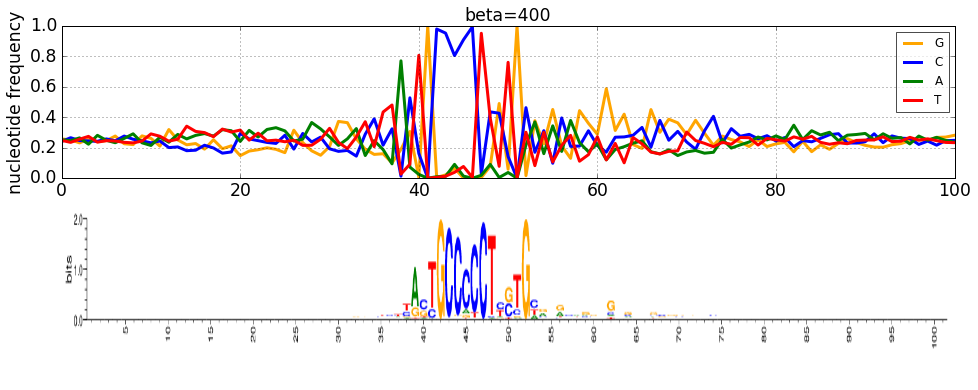

In [67]:
%matplotlib inline
figsize = (16, 6)
fig ,axes = plt.subplots( figsize = figsize , nrows= 2 , ncols=1 )

MEutils.plotSingleNT_marginalDistrib(NTfrequencies= NTcounts / np.sum(NTcounts, axis = 1, keepdims=True).astype(float), 
                                         ax = axes[0])
axes[0].set_title('beta=400',fontsize = 'xx-large')
MEutils.plotSeqLogo(countsArr= NTcounts , 
                    logoFormat = "png" ,
                    webLogoKwargs= {"stacksPerLine" : str( NTcounts.shape[0]) , 
                                    "aspectRatio":  "5" },
                   ax = axes[1], )

The motif output is generated by RWebLogo [2]

Next we repeat sampling for the same network input but at a small value of beta

In [72]:
## initialize the layerSampler object
layer4Sampler =layerSampler(model ,layerIdx = 4,beta =50.0 , mu = 0.0 ,
                                                   outputUnitIdxs =(1,) )

sampling using similarity of represtation at layer 4 of type <class 'keras.layers.core.Dropout'>


In [73]:
## do MCMC sampling  -  runtime ~ 30 s on quad core 3.2 GHz Intel cpu
samplesByInput = layer4Sampler.sample( interpInputs =oneHotSeqs[0:1,None , :, :] ,
                                        nbSteps = 10**4, samplePeriod =100, 
                                        chainsPerInput=50 )

In [74]:
## convert to a 1hot representation and plot the margial distribution of single nucleotide frequencies
oneHotArr = np.squeeze(MEutils.NTidx_to_1Hot(samplesByInput ) )
NTcounts = np.sum(oneHotArr , axis= 0)

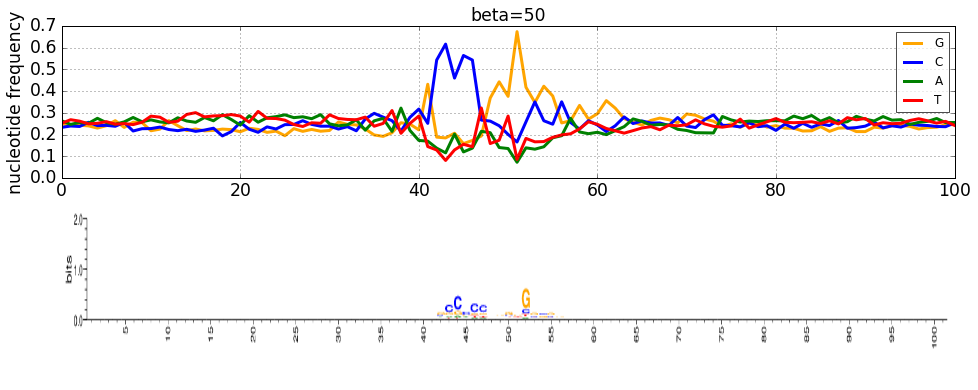

In [76]:
%matplotlib inline
figsize = (16, 6)
fig ,axes = plt.subplots( figsize = figsize , nrows= 2 , ncols=1 )

MEutils.plotSingleNT_marginalDistrib(NTfrequencies= NTcounts / np.sum(NTcounts, axis = 1, keepdims=True).astype(float), 
                                         ax = axes[0])
axes[0].set_title('beta=50',fontsize = 'xx-large')
MEutils.plotSeqLogo(countsArr= NTcounts , 
                    logoFormat = "png" ,
                    webLogoKwargs= {"stacksPerLine" : str( NTcounts.shape[0]) , 
                                    "aspectRatio":  "5" },
                   ax = axes[1], )

References:  

[1] Zeng H, Edwards MD, Liu G, Gifford DK. Convolutional neural network architectures for predicting DNA-protein binding. Bioinformatics. 2016;32(12):i121-i7. doi: 10.1093/bioinformatics/btw255. PubMed PMID: 27307608; PubMed Central PMCID: PMCPMC4908339

[2]  Crooks GE, Hon G, Chandonia JM, Brenner SE WebLogo: A sequence logo generator, Genome Research, 14:1188-1190, (2004)